<a href="https://colab.research.google.com/github/naza-campioni/fishery-models-tutorial/blob/main/SCA/sca_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this toy example we assume that our data consist of catch-at-age matrix and abundance indeces matrix.

For SCA we implement an MLE routine to estimate model parameters that best explain the data. Furthermore, we construct the matrix of numbers-at-age N_{a,y} in a foward manner:

    N_{a+1,y+1} = N_{a,y}*e^{-Z_{a,y}},
    Z_{a,y} = s_a*F_y + M_{a,y},

where F_y is the full fishing mortality in year y and s_a is the selectivity at age a which is modelled through the following logistic equation

    s_a = 1 / 1 + e^(-ln(19) * (a-a_50) / (a_95-a_50)),

where a_50 and a_95 are, respectively, the age at which selectivity is 50% and 95% [1].

Because we aim at building a statistical model so that we can implement MLE, we make the following assumptions on the following quantities [2]:

    catch totals: C_tot = ∑_y C_a,y,
    catch proportions: C_prop = C_{a,y}/∑_y C_a,y,
    abundance index: I_{a,y} = q*N_{a,y}*e^{-t_s*Z_{a,y}},

where q is the catchability coefficient.

Specifically, we assume lognormal errors for the catch totals and the abundance index and a multinomial distribution for the proportions. In reality, since the number of effective sample size of aged fish n_y is often not available, we could use a continuation-ratio logit transform on the catch proportions which allows us to model the transformed proportions with normal errors. However, for simplicity we will assume known n_y, thus

    C_tot = C_tot^*e^eps_y, eps_y ~ N(0,sigma^2_tot),
    I_{a,y} = I^_{a,y}*e^eps_{a,y}, eps_{a,y} ~ N(0,sigma^2_I),
    C_prop_y ~ Multinomial(n_y,p_y),

where the symbol ^ indicates estimates and p_y = C_{a,y}/n_y.

Then, in this toy example the vector parameter is

    theta = [a_50, a_95, F_y, q, sigma^2_tot, sigma^2_I].


**References**

[1] - Haddon, Malcom, *Modelling and Quantitative Methods in Fisheries*, Chapman&Hall/CRC, 2001.

[2] - Cadigan, Noel, *A state-space stock assessment model for northern cod, including under-reported catches and variable natural mortality rates*, Canadian Journal of Fisheries and Aquatic Sciences, 2015.

In [51]:
!git clone https://github.com/naza-campioni/fishery-models-tutorial.git

Cloning into 'fishery-models-tutorial'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 207 (delta 1), reused 0 (delta 0), pack-reused 199 (from 1)
Receiving objects: 100% (207/207), 383.34 KiB | 3.65 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [52]:
import sys
sys.path.append('/content/fishery-models-tutorial/SCA')

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tabulate import tabulate
import importlib

In [53]:
# Go to repo directory (only if you've already cloned it)
%cd /content/fishery-models-tutorial
!git pull       # to pull changes

/content/fishery-models-tutorial
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.05 KiB | 1.05 MiB/s, done.
From https://github.com/naza-campioni/fishery-models-tutorial
   345a2f3..17941b0  main       -> origin/main
Updating 345a2f3..17941b0
Fast-forward
 SCA/sca_model.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [54]:
import sca_model

In [55]:
importlib.reload(sca_model)

<module 'sca_model' from '/content/fishery-models-tutorial/SCA/sca_model.py'>

In [56]:
from sca_model import (calculate_sa,
                       calculate_N,
                       calculate_C_hat,
                       calculate_I_hat,
                       calculate_C_tot_hat,
                       calculate_C_prop_hat,
                       calculate_initial_N,
                       neg_ll,
                       fit_sca
                       )

Create synthetic data

In [57]:
np.random.seed(42)

a, y = 5, 7

# age-specific selectivity
a_50_true = 2.5
a_95_true = 4
s_true = calculate_sa(a, a_50_true, a_95_true)

# total fishing mortality
F_y_true = np.array([0.20, 0.18, 0.25, 0.32, 0.28, 0.24, 0.30])

# natural mortality
M_ay = np.ones((a,y))*0.2

# total mortality
F_ay = s_true[...,np.newaxis]*F_y_true[...,np.newaxis].T
Z = F_ay + M_ay

# catchability coefficient
q_true = 0.002

# fraction of year before survey
ts = 0.5

# 200 fish aged each year
n_y = 200

N_init_true = np.array([12000, 11000, 13500, 15000, 14000, 12500, 13000])

N_ay = calculate_N(a, y, s_true, F_y_true, M_ay, N_init_true)
C_ay = calculate_C_hat(s_true, F_y_true, M_ay, N_ay)

I_ay_true = calculate_I_hat(q_true, N_ay, ts, Z)
C_tot_true = calculate_C_tot_hat(C_ay)
C_prop_true = calculate_C_prop_hat(C_ay)

# number of proportions
n_ay = np.zeros((a, y), dtype=int)

for j in range(y):  # loop over years
  n_ay[:, j] = np.random.multinomial(n_y, C_prop_true[:, j])
C_prop = n_ay / n_ay.sum(axis=0, keepdims=True)     # effectively adding noise

# add noise
sigma_tot = 0.1
eps_tot = np.random.normal(0, sigma_tot, size=y)
C_tot = C_tot_true * np.exp(eps_tot)

sigma_I = 0.2
eps_I = np.random.normal(0, sigma_I, size=y)
I_ay = I_ay_true * np.exp(eps_I)

# sigma_prop = 0.3
# cr_prop = convert(a, C_ay)
# eps_prop = np.random.normal(0, sigma_prop, size=cr_prop.shape)
# cr_prop = cr_prop + eps_prop
# C_prop = inv_convert(a, cr_prop)






Load initial values

In [58]:
# selectivity curve
a_50 = 1
a_95 = 3
sa = calculate_sa(a, a_50, a_95)

# total fishing mortality
F_y = np.ones(y)*0.2

# catchability coefficient
q = 0.001

# variances
s_tot = 0.2
s_I = 0.3
# s_prop = 0.2

# counts
n_y_init = np.full(y, 200, dtype=int)

N_init = calculate_initial_N(sa, F_y, M_ay, C_ay)

theta_init = [a_50, a_95, *np.log(F_y), *np.log(N_init), np.log(q), np.log(s_tot), np.log(s_I)] #, *np.log(n_y_init)]
# theta_init = [a_50, a_95, *F_y, *N_init, q, s_tot, s_I, s_prop]


data = {
    'a': a,
    'y': y,
    'C_ay': C_ay,
    'I_ay': I_ay,
    'M_ay': M_ay,
    'ts': ts,
    'C_prop': C_prop,
    'C_tot': C_tot,
    'n_y': n_y
}



Run model

In [60]:
result = fit_sca(data, theta_init)
print(result)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1261.7976444797305
        x: [ 2.476e+00  3.955e+00 ... -5.349e-01 -2.182e+00]
      nit: 186
      jac: [-1.109e-01  2.954e-02 ... -1.089e-02  2.797e-03]
     nfev: 4160
     njev: 208
 hess_inv: <19x19 LbfgsInvHessProduct with dtype=float64>


In [61]:
best_params = result.x

a_50_best = best_params[0]
a_95_best = best_params[1]
F_y_best = np.exp(best_params[2:2+y])
N_init_best = np.exp(best_params[2+y:2+2*y])
q_best = np.exp(best_params[-3])
sigma_tot_best = np.exp(best_params[-2])
sigma_I_best = np.exp(best_params[-1])

In [62]:
print('a_50: {} {}'.format(a_50_best, a_50_true))
print('a_95: {} {}'.format(a_95_best, a_95_true))

print('F_y: {} {}'.format(F_y_best, F_y_true))

print('N_init: {} {}'.format(N_init_best, N_init_true))

print('q: {} {}'.format(q_best, q_true))

print('sigma_tot: {} {}'.format(sigma_tot_best, sigma_tot))

print('sigma_I: {} {}'.format(sigma_I_best, sigma_I))


a_50: 2.4757911448778707 2.5
a_95: 3.955338065121907 4
F_y: [0.21914016 0.10408482 0.09318416 0.12671854 0.3304593  0.35226247
 0.37531995] [0.2  0.18 0.25 0.32 0.28 0.24 0.3 ]
N_init: [12894.5448219  14462.09307034 19337.85840659 21042.72010802
 18549.95727756 16720.70702582 17006.92366306] [12000 11000 13500 15000 14000 12500 13000]
q: 0.0014768344325402868 0.002
sigma_tot: 0.5857564448614063 0.1
sigma_I: 0.11276641899278471 0.2


In [64]:
s_best = calculate_sa(a, a_50_best, a_95_best)
Z_best = s_best[...,np.newaxis]*F_y_best[...,np.newaxis].T + M_ay

N_ay_best = calculate_N(a, y, s_best, F_y_best, M_ay, N_init_best)
C_hat_best = calculate_C_hat(s_best, F_y_best, M_ay, N_ay_best)

I_hat_best = calculate_I_hat(q_best, N_ay_best, ts, Z_best)
C_tot_hat_best = calculate_C_tot_hat(C_hat_best)
C_prop_hat_best = calculate_C_prop_hat(C_hat_best)

Text(0.5, 1.0, 'Total catch per year')

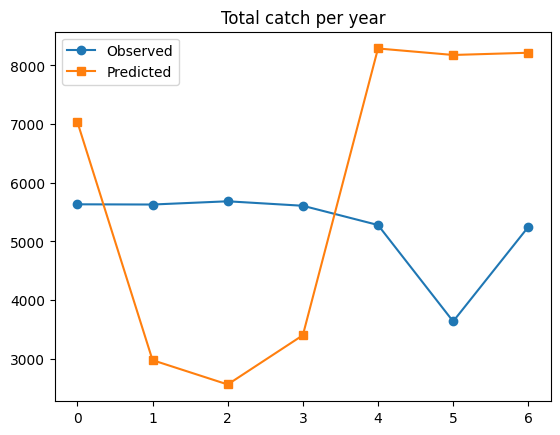

In [65]:
plt.plot(C_tot, 'o-', label='Observed')
plt.plot(C_tot_hat_best, 's-', label='Predicted')
plt.legend(); plt.title("Total catch per year")


Text(0.5, 1.0, 'Survey index')

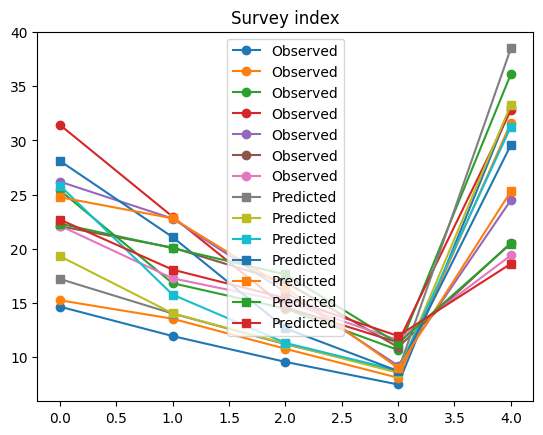

In [66]:
plt.plot(I_ay, 'o-', label='Observed')
plt.plot(I_hat_best, 's-', label='Predicted')
plt.legend(); plt.title("Survey index")
